In [19]:
%run "utils.ipynb"
import sqlite3
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 

from contextlib import closing 
import math

In [2]:
db_name = 'macrodata.db'
excluded = [8, 62, 60] + [i for i in range(81, 89)]
selected =(slice(None), [i for i in range(1, 89) if i not in [8, 62, 60] + [i for i in range(81, 89)]])

def clean_output_table(table_name, selected, excluded_sectors):
    with closing(sqlite3.connect(db_name)) as engine:
        df = pd.read_sql('SELECT * FROM %s' %(table_name), engine).set_index(['year', 'sector_id'])
        df = df.loc[selected,:]
        df = df.drop(columns=[str(x) for x in excluded])
        df.reset_index().set_index(['year']).to_sql('filtered_%s' %(table_name), engine, index=True, if_exists='replace', index_label=['year'])
        
with closing(sqlite3.connect(db_name)) as engine:
    df = pd.read_sql('SELECT * FROM klems_nominal', engine).set_index(['year', 'sector_id'])
    excluded_sectors = df.columns[[3+x for x in excluded]].values
    included_sectors = df.columns[4:].difference(excluded_sectors).values
    aggregates = np.concatenate((['year', 'sector_id'], df.columns[:4].values))
    clean_output_table('klems_nominal', selected, excluded_sectors)
    clean_output_table('klems_real', selected, excluded_sectors)

In [3]:
with closing(sqlite3.connect(db_name)) as engine:
    df = pd.read_sql('SELECT * FROM filtered_klems_nominal', engine).set_index(['year', 'sector_id'])

In [4]:

def get_aggregated_results(df, selected):
    capital = df[['capital']].loc[selected,:].reset_index()
    labor = df[['labor']].loc[selected,:].reset_index()
    vadded = df[['capital', 'labor']].loc[selected,:].reset_index()
    output = df[['output']].loc[selected,:].reset_index()
    vadded_by_sector = pd.pivot_table(vadded,index=['year'], columns=['sector_id']).groupby(level=1, axis=1).sum()
    vadded_aggregate = pd.pivot_table(vadded,index=['year'], columns=['sector_id']).groupby(level=0, axis=1).sum()
    output_by_sector = pd.pivot_table(output,index=['year'], columns=['sector_id']).groupby(level=1, axis=1).sum()
    output_aggregate = pd.pivot_table(output,index=['year'], columns=['sector_id']).groupby(level=0, axis=1).sum()
    domar_weights = output_by_sector.apply(lambda x: x / vadded_aggregate.sum(axis=1).values)
    vadded_weights = vadded_by_sector.apply(lambda x: x / vadded_aggregate.sum(axis=1).values)
    capital_share = capital / output 
    labor_share = labor / output 
    scope = locals()
    return({item: eval(item, scope).reset_index().set_index(['year']) for item in 
            ['vadded_by_sector', 'vadded_aggregate', 'output_by_sector', 'output_aggregate', 'domar_weights', 'vadded_weights', 'capital_share', 'labor_share']})

In [5]:
with closing(sqlite3.connect(db_name)) as engine:
    nominal_df = pd.read_sql('SELECT * FROM klems_nominal', engine).set_index(['year', 'sector_id'])
    sectors = nominal_df.columns[4:]
    results = get_aggregated_results(nominal_df, selected)
    for table_name, rows in results.items():
        print('Writing [%s] into the database.' %(table_name))
        rows.to_sql(table_name, engine, index=True, if_exists='replace', index_label=['year'])

Writing [vadded_by_sector] into the database.
Writing [vadded_aggregate] into the database.
Writing [output_by_sector] into the database.
Writing [output_aggregate] into the database.
Writing [domar_weights] into the database.
Writing [vadded_weights] into the database.
Writing [capital_share] into the database.
Writing [labor_share] into the database.


In [6]:
with closing(sqlite3.connect(db_name)) as engine:
    real_df = pd.read_sql('SELECT * FROM filtered_klems_real', engine).set_index(['year', 'sector_id']).loc[selected,:].reset_index()
    real_df.sort_values(['sector_id', 'year'], inplace=True, kind='mergesort')
    nominal_df = pd.read_sql('SELECT * FROM filtered_klems_nominal', engine).set_index(['year', 'sector_id']).loc[selected,:].reset_index()
    nominal_df.sort_values(['sector_id', 'year'], inplace=True, kind='mergesort')
    real_df['year'], nominal_df['year'] = pd.to_datetime(real_df['year'], format='%Y'), pd.to_datetime(nominal_df['year'], format='%Y')    

In [7]:
aggregates = ['output', 'capital', 'labor']

def get_growth_rates(in_df, log):
    df = in_df.copy(); df.iloc[:,[i for i in range(3,84)]] = df.iloc[:,[i for i in range(3,84)]].applymap(log)
    df = df.set_index(['year', 'sector_id'])
    return(df.groupby('sector_id', sort=False).diff().reset_index().set_index(['year', 'sector_id']))

def get_rollavg_shares(in_df):
    df = in_df.copy().drop(columns='sector')
    df['inputs'] = df['output'] - df['capital'] - df['labor']
    df[[x for x in df.columns.values if x.isdigit()]] = df[[x for x in df.columns.values if x.isdigit()]].apply(lambda x: x / df.inputs.values)
    df[aggregates] = df[aggregates].apply(lambda x: x / df.output.values)
    df = df.set_index(['year', 'sector_id'])
    return(df.reset_index().set_index(['year']).groupby('sector_id').rolling(2).mean().drop(columns=['inputs', 'sector_id']))


In [8]:
log_diffs = get_growth_rates(real_df, log=lambda x: math.log(x) if x > 0 else 0).fillna(0)
avg_share = get_rollavg_shares(nominal_df).fillna(0)
avg_share.index = log_diffs.index
tornqvist = (avg_share[[x for x in avg_share.columns if x.isdigit()]] * log_diffs[[x for x in log_diffs.columns if x.isdigit()]]).sum(axis=1)
tornqvist[tornqvist.index.get_level_values(0).year == 1960] = 0

In [9]:
ndf = nominal_df.copy().set_index(['year', 'sector_id']); xi = pd.DataFrame(ndf['output'] - ndf['capital'] - ndf['labor'])

In [10]:
base_year = 1996; base_ix = 46 - 1 - (2005 - base_year)
levels = tornqvist.fillna(0).apply(math.exp).groupby('sector_id').cumprod()
levels = levels.groupby('year').apply(lambda x: x / levels.groupby('sector_id').nth(base_ix))
rebased_levels = levels.groupby('year').apply(lambda x: x * xi.groupby('sector_id').nth(base_ix).values.flatten()).unstack('sector_id')
rebased_prices = xi.unstack('sector_id') / rebased_levels 

In [11]:
ldiffs = log_diffs[log_diffs.index.get_level_values(0).year > 1960]
shares = avg_share[avg_share.index.get_level_values(0).year > 1960]
tqvist = tornqvist[tornqvist.index.get_level_values(0).year > 1960]
sectoral_tfp = (ldiffs.output.unstack() - (ldiffs.capital * shares.capital).unstack() - (ldiffs.labor * shares.labor).unstack() - (1 - (shares.capital + shares.labor)).unstack() * tqvist.unstack())
sectoral_tfp_vadd = sectoral_tfp / (shares.capital + shares.labor).unstack()

In [12]:
input_share = pd.DataFrame(((ndf.output - ndf.capital - ndf.labor) / ndf.output).unstack('sector_id'))
avg_input_share = input_share.rolling(2).mean().stack()
avg_input_share.index = tqvist.index

In [13]:
with closing(sqlite3.connect(db_name)) as engine:
    domar_weights = pd.read_sql('SELECT * FROM domar_weights', engine)
    value_weights = pd.read_sql('SELECT * FROM vadded_weights', engine)
    domar_weights['year'], value_weights['year'] = pd.to_datetime(domar_weights['year'], format='%Y'), pd.to_datetime(value_weights['year'], format='%Y')    
    domar_weights = domar_weights.set_index('year')
    value_weights = value_weights.set_index('year')

In [14]:
avg_domar_weights = domar_weights.rolling(2).mean()[domar_weights.index.year > 1960]
avg_value_weights = value_weights.rolling(2).mean()[value_weights.index.year > 1960]
avg_value_share = (shares.capital + shares.labor).unstack()
aggregate_tfp_growth = pd.DataFrame(np.sum((avg_domar_weights.values * sectoral_tfp.values), axis=1), index=pd.date_range(start='1961-01-01', end='2005-01-01', freq='AS'))

In [23]:
tfp_covars = np.cov(np.vstack([np.zeros((77)), sectoral_tfp.values]), rowvar=False)
fundamental_vol_diag = domar_weights.apply(lambda x: (x*tfp_covars.diagonal())**2, axis=1).sum(axis=1)
fundamental_vol_full = pd.Series(np.apply_along_axis(lambda x: (np.multiply.outer(x, x) * tfp_covars).sum(), 1, domar_weights.values), index=fundamental_vol_diag.index)
fundamental_vol_df = pd.DataFrame({'inner': fundamental_vol_diag, 'outer': fundamental_vol_full}).applymap(np.sqrt)
fundamental_vol_df = fundamental_vol_df.sub(fundamental_vol_df.mean(axis=0), axis=1)

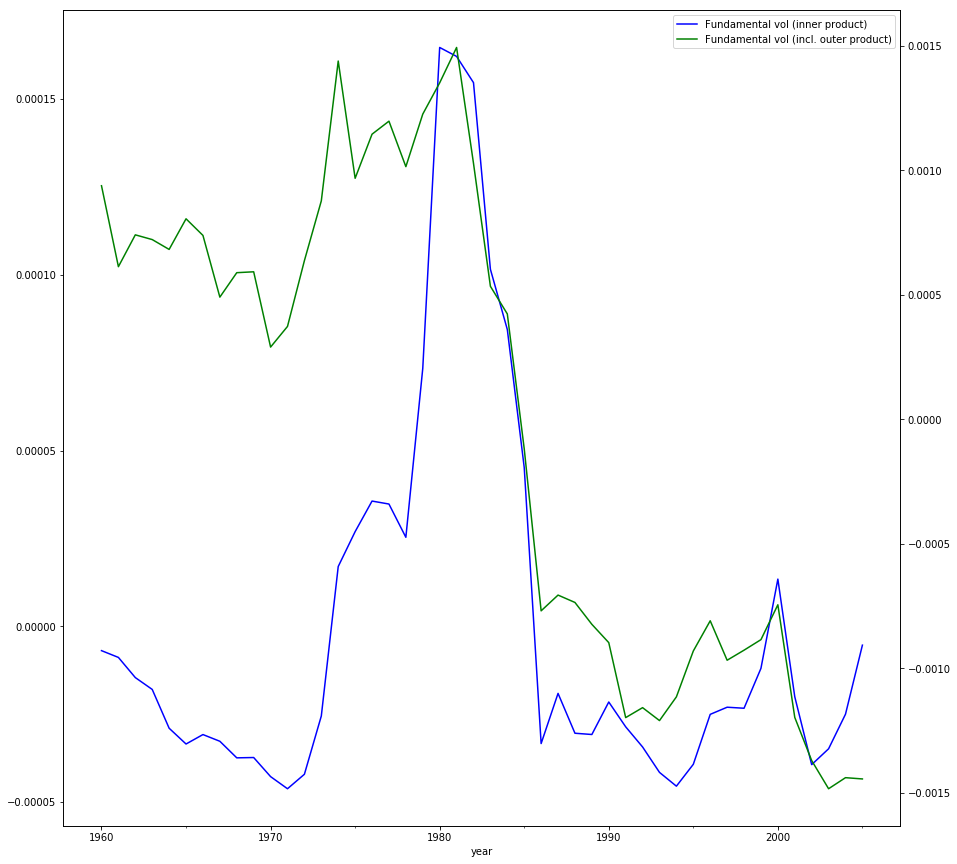

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
fundamental_vol_df.inner.plot(ax=ax, style='b-')
fundamental_vol_df.outer.plot(ax=ax, style='g-', secondary_y=True)
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]], ['Fundamental vol (inner product)', 'Fundamental vol (incl. outer product)'], loc='best')

In [26]:
fundamental_vol_df

,inner,outer
year,,
1960-01-01,-0.0000069498,0.0009382671
1961-01-01,-0.0000088801,0.0006132345
1962-01-01,-0.0000146178,0.0007410782
1963-01-01,-0.0000179874,0.0007220823
1964-01-01,-0.0000290287,0.0006825486
1965-01-01,-0.0000335195,0.0008054901
1966-01-01,-0.0000308333,0.0007387641
1967-01-01,-0.0000327428,0.0004910103
1968-01-01,-0.0000374574,0.0005891385
